In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures


import seaborn as sns

In [2]:
loans_raw = pd.read_csv("https://raw.githubusercontent.com/mrbarron3/stat451/main/loan_data.csv")
loans_p = loans_raw[["purpose", "int.rate", "installment", "log.annual.inc", "dti", "fico", "days.with.cr.line", "revol.bal", "delinq.2yrs", "not.fully.paid"]]

loans = loans_p.join(pd.get_dummies(loans_p.purpose))
loans = loans.drop("purpose", axis=1)

header = list(loans.columns)

print(len(loans_raw))

9578


In [3]:
loans_p

,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,delinq.2yrs,not.fully.paid
0,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,0,0
1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,0,0
2,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,0,0
3,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,0,0
4,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,1,0
...,...,...,...,...,...,...,...,...,...,...
9573,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,0,1
9574,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,0,1
9575,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,0,1
9576,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,0,1


In [4]:
loans.describe()

,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,delinq.2yrs,not.fully.paid,all_other,credit_card,debt_consolidation,educational,home_improvement,major_purchase,small_business
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,0.163708,0.160054,0.243370,0.131760,0.413134,0.035811,0.065671,0.045625,0.064627
std,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,0.546215,0.366676,0.429139,0.338248,0.492422,0.185829,0.247720,0.208682,0.245880
min,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


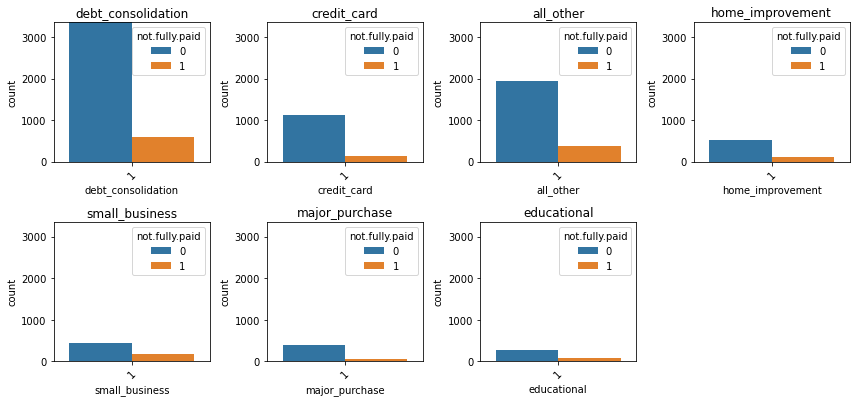

In [5]:
# Adjusting the code to set the same y-axis scale for all subplots

# Extracting the loan purposes
loan_purposes = []
for purpose in loans_p["purpose"]:
    if purpose not in loan_purposes:
        loan_purposes.append(purpose)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Creating a grid of countplots
max_y = 0  
for purpose in loan_purposes:
    df = loans[loans[purpose] == 1]
    current_plot = sns.countplot(x=df[purpose], hue=loans['not.fully.paid'], data=loans)
    max_y = max(max_y, max([p.get_height() for p in current_plot.patches]))  

for index, purpose in enumerate(loan_purposes):
    plt.subplot(3, 4, index+1)  
    sns.countplot(x=loans[loans[purpose] == 1][purpose], hue=loans['not.fully.paid'])
    plt.ylim(0, max_y)  
    plt.title(purpose)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [6]:
X = loans.drop(columns=['not.fully.paid'])
y = loans['not.fully.paid']

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2,
                                                  random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,
  random_state=0, stratify=y_tmp)


In [7]:
classifiers = [
    linear_model.LogisticRegression(max_iter=5000), 
    DecisionTreeClassifier(), 
    KNeighborsClassifier()
]
parameters = [ 
    {'C': [0.01, 1, 100]},
    {'criterion': ['entropy'], 'max_depth': [1, 3, 5, 7]},
    {'n_neighbors': [1, 2, 3, 4]}
]

best_idx = -1
best_accuracy = -np.Inf
best_clf = None

for i in range(len(classifiers)):
    if isinstance(classifiers[i], svm.SVC):
        clf = RandomizedSearchCV(classifiers[i], parameters[i])
    else:
        clf = GridSearchCV(classifiers[i], parameters[i])
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_valid, y_valid)
    if np.any(accuracy > best_accuracy):
        best_idx = i
        best_accuracy = accuracy 
        best_clf = clf
        best_params = clf.best_params_
    elif np.all(accuracy == best_accuracy):
        if type(best_clf) != list:
            best_idx = [best_idx, i]
            best_accuracy = [best_accuracy, accuracy] 
            best_clf = [best_clf, clf]
            best_params = [best_params, clf.best_params_]
        
print(f'The best classifiers are {[classifiers[best_idx[0]], classifiers[best_idx[1]]]} with the parameters {best_params}')

The best classifiers are [LogisticRegression(max_iter=5000), DecisionTreeClassifier()] with the parameters [{'C': 0.01}, {'criterion': 'entropy', 'max_depth': 1}]


In [8]:
#should we be doing lass for logistic linear? how do we do this
model = linear_model.Lasso()

model.fit(X_train, y_train)
MSE_train = (1/y_train.size) * np.sum((y_train - model.predict(X_train))**2)
MSE_test = (1/y_test.size)  * np.sum((y_test - model.predict(X_test))**2) 
w = model.coef_[1:] 
intercept = model.intercept_

print(f"MSE train: {MSE_train}, MSE test: {MSE_test}")

print(f"The coefficients are {w}")
print(f"These coefficients match up with these header names: {header}")

non_zero_vars = []
for i in range(len(w)):
    if np.isclose(w[i], 0):
        continue
    non_zero_vars.append(header[i])
    
non_zero_vars

MSE train: 0.13147711998737657, MSE test: 0.13192819345166515
The coefficients are [ 6.53160565e-05 -0.00000000e+00  0.00000000e+00 -6.87583788e-04
 -4.19157057e-06  5.89215996e-07  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00]
These coefficients match up with these header names: ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'delinq.2yrs', 'not.fully.paid', 'all_other', 'credit_card', 'debt_consolidation', 'educational', 'home_improvement', 'major_purchase', 'small_business']


['int.rate', 'dti', 'fico', 'days.with.cr.line']

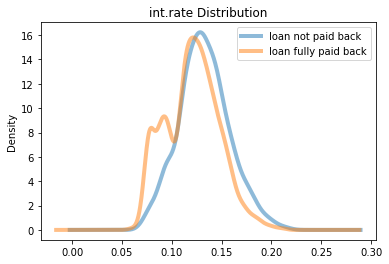

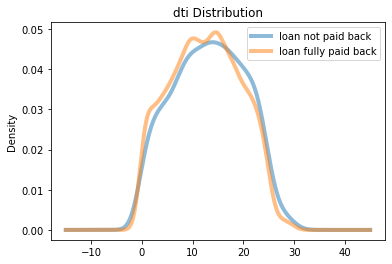

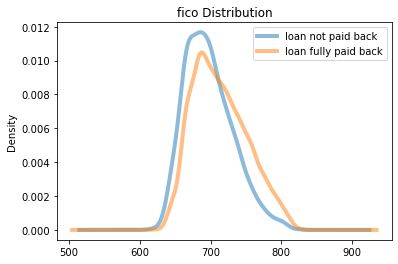

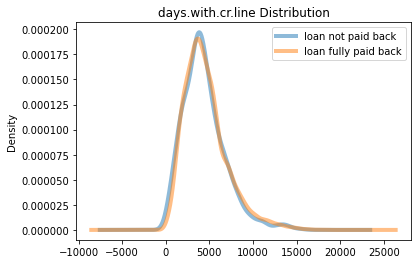

In [9]:
for var in non_zero_vars:
    loans[loans["not.fully.paid"] == 1][var].plot(kind = 'density', alpha = 0.5, label = 'loan not paid back', linewidth=4)
    loans[loans["not.fully.paid"] == 0][var].plot(kind = 'density', alpha = 0.5, label = 'loan fully paid back', linewidth=4)
    
    plt.title(f"{var} Distribution")
    plt.legend()
    plt.show(block=False)

In [10]:
model2 = linear_model.Ridge()

model2.fit(X_train, y_train)
MSE_train2 = (1/y_train.size) * np.sum((y_train - model2.predict(X_train))**2)
MSE_test2 = (1/y_test.size)  * np.sum((y_test - model2.predict(X_test))**2) 
w2 = model2.coef_[1:] 
intercept = model2.intercept_

print(f"Ridge MSE train: {MSE_train2}, Ridge MSE test: {MSE_test2}")
print(f"Lasso MSE train: {MSE_train}, Lasso MSE test: {MSE_test}")




Ridge MSE train: 0.1281157845689264, Ridge MSE test: 0.12832770449813402
Lasso MSE train: 0.13147711998737657, Lasso MSE test: 0.13192819345166515


In [11]:
#plot the training data, test data, lasso,ridge, and log regression through a graph like in https://pages.stat.wisc.edu/~jgillett/451/burkov/05/05modelFitRegularize.html


pi.importances_mean=[ 0.00000000e+00 -2.08811861e-05  0.00000000e+00  0.00000000e+00
 -2.08811861e-05 -1.25287116e-04  1.87930674e-04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]


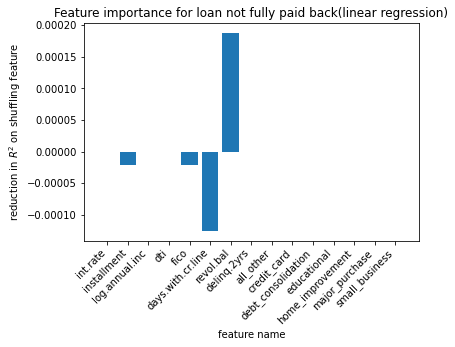

In [12]:
modelPerm = linear_model.LogisticRegression(C=.01)
# Also try varying C, above.
modelPerm.fit(X, y)

pi = permutation_importance(estimator=modelPerm, X=X, y=y, random_state=0)
print(f'pi.importances_mean={pi.importances_mean}')
#print(f'pi.importances_std={pi.importances_std}')
#print(f'pi.importances={pi.importances}')
plt.bar(x=range(X.columns.size), height=pi.importances_mean, tick_label=X.columns)
plt.xticks(rotation=45, ha='right')
plt.title('Feature importance for loan not fully paid back(linear regression)')
plt.xlabel('feature name')
_ = plt.ylabel(r'reduction in $R^2$ on shuffling feature')

pi.importances_mean=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
pi.importances_std=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
pi.importances=[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


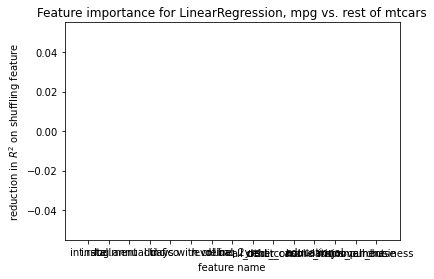

In [13]:
#why doesn't this work

modelPerm2 = DecisionTreeClassifier(criterion='entropy', max_depth= 1)

modelPerm2.fit(X, y)

pi = permutation_importance(estimator=modelPerm2, X=X, y=y, random_state=0)
print(f'pi.importances_mean={pi.importances_mean}')
print(f'pi.importances_std={pi.importances_std}')
print(f'pi.importances={pi.importances}')
plt.bar(x=range(X.columns.size), height=pi.importances_mean, tick_label=X.columns)
plt.title('Feature importance for LinearRegression, mpg vs. rest of mtcars')
plt.xlabel('feature name')
_ = plt.ylabel(r'reduction in $R^2$ on shuffling feature')

In [14]:
#more to do: feature engineering like data cleaning, rescaling, and imputation.
